### Notebook goal:
The idea here is to make a few analysis on the dataset using Python.

Summary:
- Loading data
- Word Cloud: What are the most common words used in the job descriptions?
- Top 10 locations with more job opportunities 
- Association Rules: What are the tools that are usually requested together in the job descriptions?
- Top 20 tools by tool type and job position (analista de dados and cientista de dados)

In [1]:
import sqlalchemy as db

import pandas as pd
import yaml

from wordcloud import WordCloud, STOPWORDS

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.widgets import RadioButtons

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

### Loading data

In [2]:
# Connect to MySQL
credentials = yaml.full_load(open('./credentials.yml'))
user = credentials['database']['username']
password = credentials['database']['password']
host = credentials['database']['hostname']
database = 'indeed_jobs'

string_conexao = f'mysql://{user}:{password}@{host}/{database}'
engine = db.create_engine(string_conexao)
conn = engine.connect()
conn

In [3]:
metadata = db.MetaData()
job = db.Table('job_descriptions', metadata, autoload_with=engine)

print(job.columns.keys())

['id', 'indeed_link', 'description', 'indeed_title', 'position', 'location']


In [4]:
query = db.select(job)
results = conn.execute(query).fetchall()
df = pd.DataFrame(results)
df.head()

,id,indeed_link,description,indeed_title,position,location
0,1,https://br.indeed.com/rc/clk?jk=6ac6aac0697797...,"Somos uma empresa apaixonada por pessoas, paut...",Cientista de Dados - Junior (Remoto),Cientista de Dados,Remoto
1,2,https://br.indeed.com/rc/clk?jk=45466838932b13...,Somos uma logtech líder no segmento de transpo...,CIENTISTA DE DADOS (REMOTO),Cientista de Dados,Remoto
2,3,https://br.indeed.com/rc/clk?jk=88183160ba6b40...,"Aqui na Provu, foco, responsabilidade, coopera...",Cientista de Dados Pleno,Cientista de Dados,Remoto
3,4,https://br.indeed.com/rc/clk?jk=51a6fdcdd61c48...,O que nos move diariamente?. Todos os dias via...,PESSOA CIENTISTA DE DADOS PLENO,Cientista de Dados,Remoto
4,5,https://br.indeed.com/rc/clk?jk=41427546a9ab84...,Vaga para nosso BANCO DE TALENTOS. Procuramos ...,Cientista de Dados,Cientista de Dados,Remoto


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            449 non-null    int64 
 1   indeed_link   449 non-null    object
 2   description   449 non-null    object
 3   indeed_title  449 non-null    object
 4   position      449 non-null    object
 5   location      449 non-null    object
dtypes: int64(1), object(5)
memory usage: 21.2+ KB


In [6]:
palette = sns.cubehelix_palette(n_colors=10, start=2, rot=0, dark=0.2, light=.90, reverse=True)
palette

[[0.10594437701729387, 0.2595954155696996, 0.13686591999999995],
 [0.16032846418242283, 0.35326360140355206, 0.19915574575932327],
 [0.22194481762842116, 0.44234928700136456, 0.2663001720569011],
 [0.2871792400447748, 0.5227361474756544, 0.33458395078815834],
 [0.3628985127384684, 0.602885957613189, 0.41119484813533247],
 [0.4458500517130314, 0.6784532675146836, 0.4926603460207612],
 [0.5360338569684637, 0.7494380771801382, 0.5789804444444443],
 [0.6334499285047654, 0.815840386609553, 0.6701551434063822],
 [0.7380982663219364, 0.8776601958029278, 0.7661844429065743],
 [0.8499788704199769, 0.9348975047602627, 0.8670683429450211]]

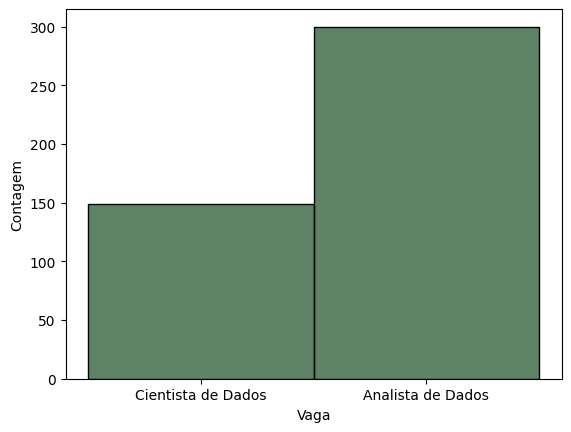

In [7]:
ax = sns.histplot(data=df, x="position", color=palette[1])
ax.set(xlabel='Vaga', ylabel='Contagem')
plt.show()

### Word Cloud

In [8]:
all_descriptions = " ".join(list(df.description))
len(all_descriptions)

1097675

In [9]:
with open("stopwords.txt", 'r', encoding='utf8') as f:
    pt_stopwords =  f.readlines()
pt_stopwords = [word[:-2] for word in pt_stopwords]
# Add english stopwords because I saw some "and", "of" in the word cloud bellow.
pt_stopwords.extend(STOPWORDS)
# Words that do not add much information and has high frequency in the descriptions.
pt_stopwords.extend(["etc", "requisito", "requisitos", "dia", "todo", "todos", "toda", "vaga", "somos", "aqui", 
                     "brasil", "empresa", "área", "trabalho", "trabalhar"])

#### All descriptions

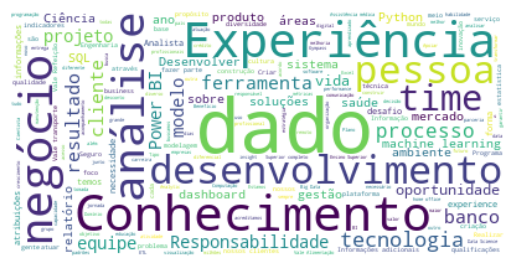

In [10]:
wordcloud = WordCloud(stopwords=pt_stopwords, background_color="white").generate(all_descriptions)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Data Scientist

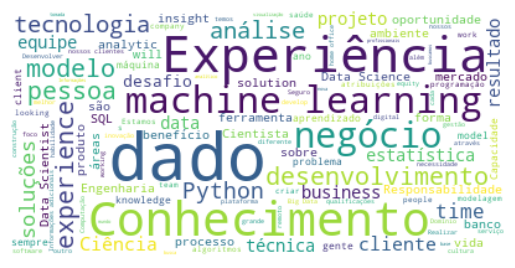

In [11]:
df_data_science = df.loc[df.position == "Cientista de Dados"]
all_descriptions = " ".join(list(df_data_science.description))
wordcloud = WordCloud(stopwords=pt_stopwords, background_color="white").generate(all_descriptions)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Data Analyst

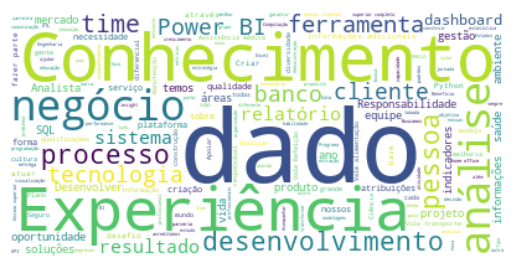

In [12]:
df_data_analyst = df.loc[df.position == "Analista de Dados"]
all_descriptions = " ".join(list(df_data_analyst.description))
wordcloud = WordCloud(stopwords=pt_stopwords, background_color="white").generate(all_descriptions)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Top 10 locations with more job opportunities

In [26]:
top_location = df.location.value_counts().head(10).to_frame()
top_location.reset_index(inplace=True)
top_location

,index,location
0,"São Paulo, SP",120
1,Remoto,75
2,"Rio de Janeiro, RJ",24
3,"Curitiba, PR",24
4,"Brasília, DF",20
5,"Porto Alegre, RS",20
6,"Belo Horizonte, MG",14
7,"Florianópolis, SC",9
8,"Barueri, SP",8
9,"Joinville, SC",6


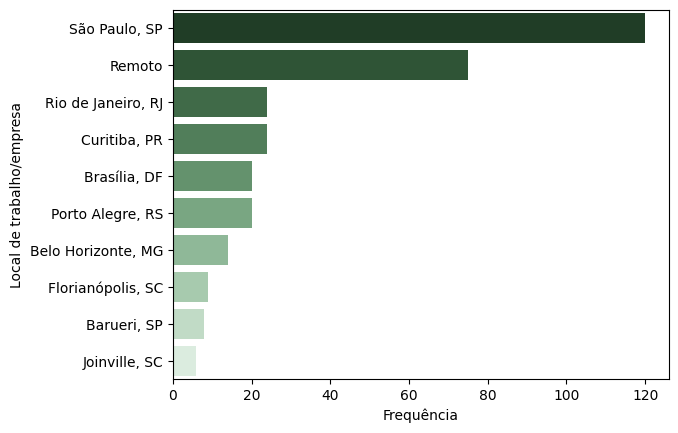

In [27]:
ax = sns.barplot(data=top_location, x='location', y='index', palette=palette)
ax.set(xlabel='Frequência', ylabel='Local de trabalho/empresa')
plt.show()

### Association Rules: What are the tools that are usually requested together in the job descriptions?

In [36]:
query = """SELECT job.id, job.position, tools.tool
        FROM job_requirements AS req
        JOIN job_descriptions AS job
        ON req.job_id = job.id
        JOIN tools
        ON req.tool_id = tools.id;"""

df_req = pd.read_sql(db.text(query), conn)
df_req.head()

,id,position,tool
0,34,Cientista de Dados,airflow
1,69,Analista de Dados,airflow
2,101,Analista de Dados,airflow
3,370,Analista de Dados,airflow
4,408,Analista de Dados,airflow


In [29]:
df_req.shape

(1359, 2)

#### Data Scientist

In [37]:
df_scientist = df_req.loc[df_req['position'] == "Cientista de Dados"]
df_scientist = df_scientist.drop("position", axis=1)
df_scientist.head()

,id,tool
0,34,airflow
6,68,alteryx
11,14,aws
12,15,aws
14,26,aws


In [38]:
one_hot = pd.get_dummies(df_scientist['tool'], dtype=bool)
df_scientist_onehot = df_scientist.drop('tool', axis = 1)
df_scientist_onehot = df_scientist_onehot.join(one_hot)
df_scientist_onehot.shape

(645, 43)

In [41]:
df_scientist_onehot = df_scientist_onehot.groupby('id').max()

In [42]:
# I was expecting 149 as it is the amount of job descriptions in the database, but it seems that 57 job descriptions
# did not have even one of the tools I added in the database. I will analyse this in the next topic.
df_scientist_onehot.shape

(134, 42)

In [43]:
df_scientist_onehot.head()

,airflow,alteryx,aws,azure,bigquery,dynamodb,gcp,go,hadoop,java,...,redshift,sas,scala,seaborn,snowflake,spark,sql,sql server,tableau,tensorflow
id,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
4,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,True,True,False,True,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [44]:
frequent_itemsets = apriori(df_scientist_onehot, min_support=0.3, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.895522,(python)
1,0.567164,(r)
2,0.619403,(sql)
3,0.529851,"(python, r)"
4,0.559701,"(sql, python)"
5,0.343284,"(sql, r)"
6,0.313433,"(python, sql, r)"


In [45]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.8)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(r),(python),0.567164,0.895522,0.529851,0.934211,1.043202,0.021943,1.588060
1,(sql),(python),0.619403,0.895522,0.559701,0.903614,1.009036,0.005012,1.083955
2,"(sql, r)",(python),0.343284,0.895522,0.313433,0.913043,1.019565,0.006015,1.201493


#### Data Analyst

In [46]:
df_analyst = df_req.loc[df_req['position'] == "Analista de Dados"]
df_analyst = df_analyst.drop("position", axis=1)
df_analyst.head()

,id,tool
1,69,airflow
2,101,airflow
3,370,airflow
4,408,airflow
5,410,airflow


In [47]:
one_hot = pd.get_dummies(df_analyst['tool'], dtype=bool)
df_analyst_onehot = df_analyst.drop('tool', axis = 1)
df_analyst_onehot = df_analyst_onehot.join(one_hot)
df_analyst_onehot.shape

(714, 40)

In [48]:
df_analyst_onehot = df_analyst_onehot.groupby('id').max()
df_analyst_onehot.shape

(246, 39)

In [50]:
frequent_itemsets = apriori(df_analyst_onehot, min_support=0.3, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.593496,(power bi)
1,0.378049,(python)
2,0.699187,(sql)
3,0.365854,"(power bi, sql)"
4,0.325203,"(python, sql)"


In [51]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.8)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(python),(sql),0.378049,0.699187,0.325203,0.860215,1.230308,0.060876,2.15197


### Check descriptions with any of the tools I manually added to the DB

In [52]:
query = """SELECT job.id, job.indeed_link, job.description
        FROM job_requirements AS req
        RIGHT JOIN job_descriptions AS job
        ON req.job_id = job.id
        WHERE req.job_id IS NULL;"""

df_job = pd.read_sql(db.text(query), conn)
df_job.head()

,id,indeed_link,description
0,8,https://br.indeed.com/rc/clk?jk=f75fb1d3d3360f...,A NAVA está em busca de uma Pessoa Cientista d...
1,12,https://br.indeed.com/rc/clk?jk=c42a13e3bf218f...,O que você precisa ter: Ensino Superior comple...
2,20,https://br.indeed.com/rc/clk?jk=3fbcad028fd24c...,Empresa de software admite Cientista de Dados ...
3,37,https://br.indeed.com/rc/clk?jk=f6820c56d17765...,Habilidade em matemática e estatística: para r...
4,54,https://br.indeed.com/rc/clk?jk=a8f5eda50c680e...,"Nós, do time de Tecnologia do EAG, estamos pro..."


In [53]:
df_job.iloc[0].description

'A NAVA está em busca de uma Pessoa Cientista de Dados para fazer parte do nosso time de pessoas incríveis!. Por que trabalhar na NAVA?. Somos uma empresa de tecnologia que atende as maiores companhias dos setores financeiro, seguros, meios de pagamento, telecomunicações, energia e varejo do país. Inspiramos nossos times a criar soluções para que essas companhias transformem e impactem positivamente o mundo. Temos um time curioso, criativo, energético e inspirador, com grande foco nas pessoas para gerar inovação, transformação e crescimento. Dentro de um ambiente dinâmico e ágil, o nosso time está em expansão para acompanhar o crescimento exponencial da NAVA e dos nossos Clientes. Responsabilidades e atribuições. Como será o seu dia a dia?. Irá atuar na análise e exploração de dados relevantes e que podem aumentar a qualidade e saúde do ambiente das esteiras de aplicações. Requisitos e qualificações. O que esperamos de você?. Gestão de Dados Estruturados. Matemática. Gestão de Projetos

In [54]:
df_job.iloc[0].indeed_link

'https://br.indeed.com/rc/clk?jk=f75fb1d3d3360f41&fccid=4df8c09240f8f9eb&vjs=3'

### Top 20 tools by tool type and job position

In [55]:
%matplotlib qt

In [56]:
query = """SELECT job.id, job.position, tools.tool, tools.tool_group
        FROM job_requirements AS req
        JOIN job_descriptions AS job
        ON req.job_id = job.id
        JOIN tools
        ON req.tool_id = tools.id;"""

df_req_all = pd.read_sql(db.text(query), conn)
df_req_all.head()

,id,position,tool,tool_group
0,1,Cientista de Dados,python,Linguagem
1,2,Cientista de Dados,python,Linguagem
2,4,Cientista de Dados,python,Linguagem
3,6,Analista de Dados,python,Linguagem
4,7,Cientista de Dados,python,Linguagem


In [88]:
palette = sns.cubehelix_palette(n_colors=20, start=2, rot=0, dark=0.2, light=.90, reverse=True)
palette

[[0.10594437701729387, 0.2595954155696996, 0.13686591999999995],
 [0.12952222328934432, 0.3023131835991431, 0.16429558477508643],
 [0.15743749349999575, 0.34868902649246536, 0.19592595770857357],
 [0.18410713360711783, 0.3894477756710018, 0.22543096421376385],
 [0.21224130763611598, 0.4292785685517402, 0.2559190273279507],
 [0.24521916424337595, 0.4724466612798344, 0.290947620638216],
 [0.2764451321074458, 0.5103184353096657, 0.32351102548250665],
 [0.3128583151981187, 0.551309840425641, 0.36084555404844276],
 [0.34717607689726016, 0.5872225956045652, 0.3954843006228373],
 [0.38702458647134597, 0.6260373131084216, 0.43512476444444437],
 [0.4244341420055591, 0.6599910494364387, 0.4718388527489426],
 [0.46330823146164823, 0.6930168294666577, 0.5095359976624374],
 [0.5082193274323427, 0.728623796805286, 0.5525746818608226],
 [0.5501852107235036, 0.7596905579845981, 0.5923471685044214],
 [0.5985316331776109, 0.7931208377111074, 0.6376917879584775],
 [0.6435893103038434, 0.8222285800395123, 0.6795396163321799],
 [0.6953710592413637, 0.8534821721539027, 0.7271901710419069],
 [0.7435205302026677, 0.8806308956314005, 0.7711133411457131],
 [0.7931345350858481, 0.9068516628111003, 0.8160195678585159],
 [0.8499788704199769, 0.9348975047602627, 0.8670683429450211]]

### Data Science plot (external window)

In [89]:
df_req_ciencia = df_req_all.loc[df_req_all["position"] == "Cientista de Dados"]

In [90]:
n_jobs = df.loc[df['position'] == 'Cientista de Dados'].shape[0]
df_req_ciencia = df_req_ciencia.groupby(["tool", "tool_group", "position"]).count()
df_req_ciencia['perc'] = (df_req_ciencia['id']/n_jobs) * 100 
df_req_ciencia['perc_str'] = df_req_ciencia['perc'].apply(lambda x: str(round(x, 1)) + "%")
df_req_ciencia = df_req_ciencia.reset_index()
df_req_ciencia = df_req_ciencia.sort_values("perc", ascending=False)
df_req_ciencia.head()

,tool,tool_group,position,id,perc,perc_str
27,python,Linguagem,Cientista de Dados,120,80.536913,80.5%
38,sql,Linguagem,Cientista de Dados,83,55.704698,55.7%
30,r,Linguagem,Cientista de Dados,76,51.006711,51.0%
2,aws,Cloud,Cientista de Dados,31,20.805369,20.8%
37,spark,Bibliotecas,Cientista de Dados,27,18.120805,18.1%


In [130]:
fig, ax = plt.subplots(figsize=(12, 12))
i = sns.barplot(data=df_req_ciencia.head(20), x="perc", y='tool', palette=palette, ax=ax)
i.bar_label(ax.containers[0], df_req_ciencia.head(20)['perc_str'])
i.set(xticklabels=[])
i.tick_params(bottom=False)
i.set_title("Ferramentas VS porcentagem de vagas para Cientista de Dados")
plt.subplots_adjust(left=0.4)
ax.set(xlabel='', ylabel='Ferramentas')

tool_type = plt.axes([0.1, 0.4, 0.2, 0.2])
type_button = RadioButtons(tool_type, ('Todos',
                                  'Linguagem',
                                  'Ferramentas',
                                  'Database',
                                  'Cloud',
                                  'Bibliotecas'))
def tool_type_filter(label):
    ax.cla()
    if label == "Todos":
        data = df_req_ciencia.head(20)
    else:
        data = df_req_ciencia.loc[df_req_ciencia["tool_group"] == label].head(20)
        
    i = sns.barplot(data=data, x="perc", y='tool', palette=palette, ax=ax)
    i.bar_label(ax.containers[0], data['perc_str'])
    i.set(xticklabels=[])
    i.set_title("Ferramentas VS porcentagem de vagas para Cientista de Dados")
    plt.draw()

type_button.on_clicked(tool_type_filter)

plt.show()

### Data Analysis plot (external window)

In [119]:
df_req_analise = df_req_all.loc[df_req_all["position"] == "Analista de Dados"]

In [120]:
n_jobs = df.loc[df['position'] == 'Analista de Dados'].shape[0]
df_req_analise = df_req_analise.groupby(["tool", "tool_group", "position"]).count()
df_req_analise['perc'] = (df_req_analise['id']/n_jobs) * 100 
df_req_analise['perc_str'] = df_req_analise['perc'].apply(lambda x: str(round(x, 1)) + "%")
df_req_analise = df_req_analise.reset_index()
df_req_analise = df_req_analise.sort_values("perc", ascending=False)
df_req_analise.head()

,tool,tool_group,position,id,perc,perc_str
35,sql,Linguagem,Analista de Dados,172,57.333333,57.3%
25,power bi,Ferramentas,Analista de Dados,146,48.666667,48.7%
27,python,Linguagem,Analista de Dados,93,31.000000,31.0%
29,r,Linguagem,Analista de Dados,55,18.333333,18.3%
37,tableau,Ferramentas,Analista de Dados,44,14.666667,14.7%


In [131]:
fig, ax = plt.subplots(figsize=(12, 12))
i = sns.barplot(data=df_req_analise.head(20), x="perc", y='tool', palette=palette, ax=ax)
i.bar_label(ax.containers[0], df_req_analise.head(20)['perc_str'])
i.set(xticklabels=[])
i.tick_params(bottom=False)
plt.subplots_adjust(left=0.4)
ax.set(xlabel='', ylabel='Ferramentas')
i.set_title("Ferramentas VS porcentagem de vagas para Analista de Dados")

tool_type = plt.axes([0.1, 0.4, 0.2, 0.2])
type_button = RadioButtons(tool_type, ('Todos',
                                  'Linguagem',
                                  'Ferramentas',
                                  'Database',
                                  'Cloud',
                                  'Bibliotecas'))
def tool_type_filter(label):
    ax.cla()
    if label == "Todos":
        data = df_req_analise.head(20)
    else:
        data = df_req_analise.loc[df_req_analise["tool_group"] == label].head(20)
        
    i = sns.barplot(data=data, x="perc", y='tool', palette=palette, ax=ax)
    i.bar_label(ax.containers[0], data['perc_str'])
    i.set(xticklabels=[])
    i.set_title("Ferramentas VS porcentagem de vagas para Analista de Dados")
    ax.set(xlabel='', ylabel='Ferramentas')
    plt.draw()
 
 
type_button.on_clicked(tool_type_filter)

plt.show()